In [2]:
#import course;course.header()
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Retrieve COVID data from ECDC 

In [3]:
covid_url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/json/"
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import json
import urllib
from datetime import datetime

In [4]:
covid_json_unformated = urllib.request.urlopen(covid_url).read().decode("utf-8")
covid_json = json.loads(covid_json_unformated)
cdf = pd.DataFrame(covid_json['records'])

In [5]:
cdf = cdf.rename(columns={
    "countriesAndTerritories": "Country",
    "geoId": "Geo_Id",
    "countryterritoryCode": "Country_code",
    "popData2019": "Population",
    "continentExp": "Continent",
    "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000": "14d_incidence"})
cdf.sample(10)

,dateRep,day,month,year,cases,deaths,Country,Geo_Id,Country_code,Population,Continent,14d_incidence
32518,12/06/2020,12,06,2020,2,0,Latvia,LV,LVA,1.919968e+06,Europe,1.71877865
56723,20/10/2020,20,10,2020,2185,61,Tunisia,TN,TUN,1.169472e+07,Africa,164.80940417
38155,11/05/2020,11,05,2020,0,0,Mongolia,MN,MNG,3.225166e+06,Asia,0.12402462
30667,31/10/2020,31,10,2020,633,2,Kazakhstan,KZ,KAZ,1.855143e+07,Asia,25.2271685
12177,26/09/2020,26,09,2020,17,1,China,CN,CHN,1.433784e+09,Asia,0.02064468
25570,04/12/2020,04,12,2020,0,0,Holy_See,VA,VAT,8.150000e+02,Europe,0
51998,07/07/2020,07,07,2020,8971,111,South_Africa,ZA,ZAF,5.855827e+07,Africa,177.82459307
35458,02/04/2020,02,04,2020,142,2,Malaysia,MY,MYS,3.194979e+07,Asia,6.62915176
23949,27/11/2020,27,11,2020,696,26,Guatemala,GT,GTM,1.758148e+07,America,40.62230043
48131,27/10/2020,27,10,2020,0,0,Saint_Vincent_and_the_Grenadines,VC,VCT,1.105930e+05,America,8.13794725


In [6]:

cdf['14d_incidence'] = pd.to_numeric(cdf['14d_incidence'])
cdf.astype({
    "Country":"category",
    "Geo_Id":"category",
    "Country_code":"category",
    "Continent":"category",
})
cdf.dtypes

dateRep           object
day               object
month             object
year              object
cases              int64
deaths             int64
Country           object
Geo_Id            object
Country_code      object
Population       float64
Continent         object
14d_incidence    float64
dtype: object

Rename columns to something more Pythonian. If you think they look already great, then at least rename `notification_rate_per_100000_population_14-days` to `14d-incidence`

Identify which columns have not been casted to an appropriate type during loading!

We did not cover datetime objects in pandas, however they are quite powerful!

Try:

In [7]:
cdf['date_reported'] = pd.to_datetime(cdf['dateRep'])

Now you can treat the column as a datetime objects using `df[col].dt` , e.g. https://docs.python.org/3/library/datetime.html#datetime.date.year

In [8]:
cdf['date_reported'].dt.day.head()

0    14
1    13
2    12
3    12
4    12
Name: date_reported, dtype: int64

In [9]:
cdf = cdf.drop(columns=["dateRep","day","month","year"])


In [10]:
oldest = min(cdf['date_reported'].tolist())
cdf.sample(10)
oldest

Timestamp('2019-12-31 00:00:00')

In [11]:
cdf['deltaTime_since_start_of_recording'] = cdf['date_reported']-oldest
cdf.sample(3)

,cases,deaths,Country,Geo_Id,Country_code,Population,Continent,14d_incidence,date_reported,deltaTime_since_start_of_recording
31841,484,3,Kyrgyzstan,KG,KGZ,6415851.0,Asia,115.152300,2020-10-31,305 days
11820,1714,36,Chile,CL,CHL,18952035.0,America,104.168233,2020-07-12,194 days
27595,2691,153,Iran,IR,IRN,82913893.0,Asia,43.271397,2020-09-07,251 days


Create a new column `deltaTime_since_start_of_recording`

Create histograms for different columns or describe the df. Can you spot the inconsistency in the data? Fix it! :)

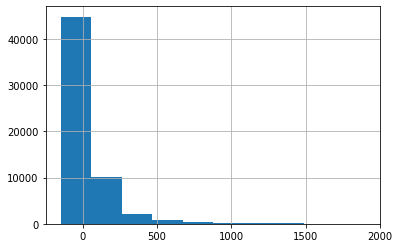

In [12]:
#cdf["deaths"].hist()
#cdf["Population"].hist()
cdf["14d_incidence"].hist()
#cdf["deltaTime_since_start_of_recording"].hist()
mask_14d = cdf["14d_incidence"] < 0
mask_deaths = cdf["deaths"] < 0
cdf = cdf.drop(cdf[mask_14d | mask_deaths].index)
#It seems that negative incidences and death rates exist.

Identify those countries (grouped by continent) which showed the most drastic increase most drastic and decrease of the `14d-incidence` within the different years since recording. Visualize intuitively!

In [13]:
cdf_2020 = cdf[cdf["date_reported"].dt.year == 2020] 
cdf_2021 = cdf[cdf["date_reported"].dt.year == 2021] 

cdf_2020["derivative"] = cdf_2020["14d_incidence"].diff() / cdf_2020["deltaTime_since_start_of_recording"].dt.days.diff()
cdf_2021["derivative"] = cdf_2021["14d_incidence"].diff() / cdf_2021["deltaTime_since_start_of_recording"].dt.days.diff()
grp_cdf_2020 = cdf_2020[['Country','derivative']].groupby(cdf_2020['Continent'])
grp_cdf_2021 = cdf_2021[['Country','derivative']].groupby(cdf_2021["Continent"])
print(grp_cdf_2020.max())
print(grp_cdf_2020.min())
print(grp_cdf_2021.max())
print(grp_cdf_2021.min())


                                              Country  derivative
Continent                                                        
Africa                                       Zimbabwe   62.311670
America                                     Venezuela  164.821350
Asia                                            Yemen  174.224744
Europe                                 United_Kingdom  858.895706
Oceania                             Wallis_and_Futuna  268.900943
Other      Cases_on_an_international_conveyance_Japan         NaN
                                              Country  derivative
Continent                                                        
Africa                                        Algeria -129.057760
America                                      Anguilla -177.935943
Asia                                      Afghanistan -108.317830
Europe                                        Albania -858.895706
Oceania                                     Australia -346.957409
Other     

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_21948/2597309103.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_2020["derivative"] = cdf_2020["14d_incidence"].diff() / cdf_2020["deltaTime_since_start_of_recording"].dt.days.diff()


Which country showed the highest/lowest fluctuation in `14d-incidence` within a year?

In [14]:
cdf_2020["Var"] = cdf_2020["14d_incidence"].var()
cdf_2021["Var"] = cdf_2021["14d_incidence"].var()
cdf_2020.dropna()
cdf_2021.dropna()
print(cdf_2020[['Country','Var']].max())
print(cdf_2020[['Country','Var']].min())
print(cdf_2021[['Country','Var']].max())
print(cdf_2021[['Country','Var']].min())
cdf_2021

Country        Zimbabwe
Var        26360.000421
dtype: object
Country     Afghanistan
Var        26360.000421
dtype: object
Country    NaN
Var        NaN
dtype: object
Country    NaN
Var        NaN
dtype: object


C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_21948/2576791923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf_2020["Var"] = cdf_2020["14d_incidence"].var()


,cases,deaths,Country,Geo_Id,Country_code,Population,Continent,14d_incidence,date_reported,deltaTime_since_start_of_recording,derivative,Var


Create a line plot showing the `14-incidence` for all European countries. Use `groupby` operation to generate the data list for the plotly plot. 

In [25]:
cdf_EU = cdf[cdf["Continent"] == "Europe"] 
cdf_EU = cdf_EU.sort_values(by = ["date_reported"])
EU_countries = cdf_EU["Country"].unique()
grp_country = cdf_EU[['Country','14d_incidence',"date_reported"]].groupby(cdf_EU['Country'])

x_list = []
y_list = []
fig = go.Figure()
for country in EU_countries:
    cdf_country_EU = cdf_EU[cdf_EU["Country"] == country] 
    fig.add_trace(go.Scatter(x=cdf_country_EU["date_reported"], y=cdf_country_EU["14d_incidence"], name=country,
                line_shape='spline'))
    y_list.append(cdf_country_EU["14d_incidence"])
    x_list.append(cdf_country_EU["date_reported"])
#fig = px.line(grp_country, x = "date_reported", y = "14d_incidence")

fig.show()
EU_countries


array(['United_Kingdom', 'Lithuania', 'Spain', 'Monaco', 'Azerbaijan',
       'Russia', 'San_Marino', 'North_Macedonia', 'Armenia', 'Belarus',
       'Estonia', 'Sweden', 'Ireland', 'Denmark', 'Greece', 'Germany',
       'Austria', 'Norway', 'Romania', 'Czechia', 'Iceland', 'Belgium',
       'Luxembourg', 'Switzerland', 'Georgia', 'Italy', 'Croatia',
       'France', 'Netherlands', 'Finland', 'Montenegro', 'Cyprus',
       'Serbia', 'Turkey', 'Gibraltar', 'Ukraine', 'Bulgaria',
       'Bosnia_and_Herzegovina', 'Albania', 'Latvia', 'Moldova',
       'Slovakia', 'Guernsey', 'Malta', 'Poland', 'Slovenia', 'Kosovo',
       'Holy_See', 'Faroe_Islands', 'Isle_of_Man', 'Liechtenstein',
       'Portugal', 'Hungary', 'Andorra', 'Jersey'], dtype=object)

In [24]:
y_list[0]

58727           NaN
58726           NaN
58695      0.003001
58666      0.048014
58635     45.457334
            ...    
58441    253.194767
58410    471.813392
58380    330.327892
58379    338.775370
58378    348.216139
Name: 14d_incidence, Length: 350, dtype: float64

Create a smoothed version of the `14d-incidence` by averaging 3 months.

Create a radial plot of death rate / 100000 people (see popData2019), where one year completes a circle, i.e. 360˚. Visualize the recored years for Italy, Germany, Sweden and Greece. Hint you might need to turn the dateTime into `day within the year` (%j) and adjust 365 to 360 degrees. 

Optional: Find "regular" mortality rates for those countries and visualize it in the plot as well.